In [1]:
import pandas as pd
from pandas import Series, DataFrame
import os
import datetime
from sklearn import preprocessing
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl
import math

C:\Users\southman\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# 문자열을 데이터 형대로 변환한다.
def to_date(date_str) :
    date_str = date_str.replace(" ", "")
    split = ""
    if date_str.find("-") > -1 :
        split = "-"
    elif date_str.find(".") > -1 :
        split = "."
    date_format = '%Y'+ split + '%m' + split + '%d'    
    return datetime.datetime.strptime(date_str, date_format)

# excel로 저장한다.
def save_excel(df_data, file_path):
    writer = pd.ExcelWriter(file_path)
    df_data.to_excel(writer,'Sheet1', index=False)
    writer.save()

# 주식회사 정보를 가져와서 엑셀로 저장한다.    
def save_comp_data() :
    url = 'http://kind.krx.co.kr/corpgeneral/corpList.do?method=download&searchType=13'
    code_df = pd.read_html(url, header=0)[0]
    save_excel(code_df, './data/comps.xlsx')

# 엘셀을 불러와서 회사 코드를 가져온다.    
def get_comp_code(comp_name) :
    file_path = './data/comps.xlsx'
    
    if os.path.isfile(file_path) == False :
        save_comp_data()
        
    corporations = pd.read_excel(file_path)
    comp_code = corporations.query("회사명=='{}'".format(comp_name))['종목코드'].to_string(index=False)
    return format(int(comp_code), "06d")

# 네이버 금융(http://finance.naver.com)에 넣어줌
def get_naver_url(comp_code):
    return 'http://finance.naver.com/item/sise_day.nhn?code={code}'.format(code=comp_code)

# 네이버 매일 주식정보를 가져온다.
def get_stock_naver_data(comp_code, start_date) :
    url = get_naver_url(comp_code)
    df = pd.DataFrame()
    
    # 네이버 웹 크롤링
    page = 1
    bf_date = ''
    while True :
        pg_url = '{url}&page={page}'.format(url=url, page=page)
        page_data = pd.read_html(pg_url, header=0)[0]
        page_data = page_data.dropna()
        last_date = page_data.tail(1)['날짜'].to_string(index=False)
        if bf_date == last_date :
            break
        df = df.append(page_data, ignore_index=True)
        if start_date != '' :
            if to_date(start_date) > to_date(last_date) :
                break
        if len(page_data) < 10 :
            break        
        page += 1
        bf_date = last_date 
    
    # 필요 없는 날짜 제거
    if start_date != '' :
        drop_cnt = 0
        df_len = len(df)
        for i in range(df_len) :
            last_date = df.loc[df_len-i-1, '날짜']
            if to_date(start_date) > to_date(last_date) :
                drop_cnt += 1
            else :
                break
        if drop_cnt > 0 :        
            df = df[:-drop_cnt]
    
    # 정렬 및 컬럼명 변경 
    if df.shape[0] != 0 :
        df = df.sort_values(by='날짜')
        df.rename(columns={'날짜': 'date', 
                           '종가': 'close', 
                           '전일비': 'diff', 
                           '시가': 'open', 
                           '고가': 'high',
                           '저가': 'low', 
                           '거래량': 'volume'}, inplace=True)    
    return df
    
def get_stock_data(comp_code) :
    file_path = './data/' + comp_code + '.csv'
    
    if os.path.isfile(file_path) :
        stock_data = pd.read_csv(file_path)
        stock_data = stock_data[:-1]
        date_last = stock_data.tail(1)['date'].to_string(index=False)
        date_next = to_date(date_last) + datetime.timedelta(days=1)
        date_next = date_next.strftime("%Y-%m-%d")
        new_data = get_stock_naver_data(comp_code, date_next)
        if len(new_data) > 0 :
            stock_data = stock_data.append(new_data, ignore_index=True)
            stock_data.to_csv(file_path, index=False)
    else :
        stock_data = get_stock_naver_data(comp_code, '')
        stock_data.to_csv(file_path, index=False)
    return stock_data

# matrix 데이터로 변경한다.
def to_ndarray(cols_data) :
    if isinstance(cols_data, Series):
        return np.reshape(list(cols_data), (-1,1))
    elif isinstance(cols_data, DataFrame):
        return cols_data.as_matrix()

# 컬럼을 스케일링을 시킨다.
def get_scaled_cols(data, column_name) :
    scale_data = to_ndarray(data[column_name])
    scaler = preprocessing.MinMaxScaler()
    return scaler.fit_transform(scale_data), scaler;

# 데이터를 스케일링 시킨다.
def get_scaled_data(data) :
    scaled_data = data.copy()
    scaled_data = scaled_data[['close', 'open', 'high', 'low', 'volume']]
    scaled_data = scaled_data[scaled_data['close']!=0]
    scaled_data['close'], scaler_close = get_scaled_cols(scaled_data, 'close')
    scaled_data['open'], _ = get_scaled_cols(scaled_data, 'open')
    scaled_data['high'], _ = get_scaled_cols(scaled_data, 'high')
    scaled_data['low'], _ = get_scaled_cols(scaled_data, 'low')
    scaled_data['volume'], _ = get_scaled_cols(scaled_data, 'volume')
    return scaled_data, scaler_close;

# RNN을 위한 데이터로 만든다. 
def get_dataXY(data) :
    x = to_ndarray(data)
    y = to_ndarray(data['close'])
    
    dataX = []
    dataY = []
    seq_length = params['seq_length']
    y_len = len(y)
    for i in range(0, y_len - seq_length):
        _x = x[i:i + seq_length]
        _y = y[i + seq_length] # Next close price
        dataX.append(_x)
        dataY.append(_y)
    dataX_last = [x[y_len-seq_length: y_len]]    
    return dataX, dataY, y, dataX_last

# train 및 test 데이터로 나눈다.
def split_train_test(dataX, dataY, data, y) :
    invest_count = params['invest_count']
    seq_length = params['seq_length']
    data_count = len(dataY);
    train_size = int(data_count * params['train_percent'] / 100)
    train_last = data_count-invest_count;
    
    trainX = np.array(dataX[0:train_size])
    testX = np.array(dataX[train_size:train_last])
    investX = np.array(dataX[train_last:data_count])
    
    trainY = np.array(dataY[0:train_size])
    testY = np.array(dataY[train_size:train_last])
    investY = np.array(dataY[train_last:data_count])
    
    trainCloses = np.array( y[seq_length-1:train_size+seq_length-1])
    testCloses = np.array(dataY[train_size-1:train_last-1])
    investCloses = np.array(dataY[train_last-1:data_count-1])
    investRealCloses = np.array(data['close'][train_last-1+seq_length:data_count+seq_length].values)
    #print(investRealCloses)
    return {
        'trainX': trainX, 'trainY': trainY, 'trainCloses': trainCloses,
        'testX': testX, 'testY': testY, 'testCloses' : testCloses,
        'investX': investX,'investY': investY, 'investCloses': investCloses, 'investRealCloses': investRealCloses
    }

# train, test데이터로 만든다.
def get_train_test(data) :
    scaled_data, scaler_close = get_scaled_data(data)
    dataX, dataY, y, dataX_last = get_dataXY(scaled_data)
    return split_train_test(dataX, dataY, data, y), scaler_close, dataX_last

# 텐스플로우 변수관계 그래프롤 그린다.
def draw_graph() :
    seq_length = params['seq_length']
    data_dim = params['data_dim']
    hidden_dims = params['hidden_dims']
    
    tf.reset_default_graph()
    X = tf.placeholder(tf.float32, [None, seq_length, data_dim])
    X_closes = tf.placeholder(tf.float32, [None, 1])
    Y = tf.placeholder(tf.float32, [None, 1])
    output_keep_prob = tf.placeholder(tf.float32)
    
    cells = []
    for n in hidden_dims :
        cell = tf.contrib.rnn.BasicLSTMCell(num_units=n, activation=tf.tanh)
        dropout_cell = tf.contrib.rnn.DropoutWrapper(cell, output_keep_prob=output_keep_prob)
        cells.append(dropout_cell)
    stacked_rnn_cell = tf.nn.rnn_cell.MultiRNNCell(cells)
    outputs, _states = tf.nn.dynamic_rnn(stacked_rnn_cell, X, dtype=tf.float32) 
    Y_pred = tf.contrib.layers.fully_connected(
        outputs[:, -1], params['output_dim'], activation_fn=None)  # We use the last cell's output

    # cost/loss
    loss = tf.reduce_sum(tf.square(1-(1+Y_pred-X_closes)/(1+Y-X_closes)))
        
    optimizer = tf.train.AdamOptimizer(params['learning_rate'])
    train = optimizer.minimize(loss)

    # RMSE
    targets = tf.placeholder(tf.float32, [None, 1])
    predictions = tf.placeholder(tf.float32, [None, 1])
    rmse = tf.sqrt(tf.reduce_mean(tf.square(1-(1+predictions-X_closes)/(1+targets-X_closes))))
    
    return {
        'X': X,
        'Y': Y,
        'output_keep_prob': output_keep_prob,
        'train': train,
        'loss' : loss,
        'Y_pred': Y_pred,
        'targets': targets,
        'rmse' : rmse,
        'predictions': predictions,
        'X_closes' : X_closes
    }

def draw_plot(rmse_vals, test_predict, invest_predicts, comp_name, data_params) :
    testY = data_params['testY']
    investY = data_params['investY']
    y = np.append(testY,investY)
    predict =  np.append(test_predict, invest_predicts)
    
    mpl.rcParams['axes.unicode_minus'] = False
    font_name = fm.FontProperties(fname=params['kor_font_path'], size=50).get_name()
    plt.rc('font', family=font_name)
    
    plt.figure(1)
    plt.plot(rmse_vals, 'gold')
    plt.xlabel('Epoch')
    plt.ylabel('Root Mean Square Error')
    plt.title(comp_name)

    plt.figure(2)
    plt.plot(y, 'b')
    plt.plot(predict, 'r')
    plt.xlabel('Time Period')
    plt.ylabel('Stock Price')
    plt.title(comp_name)
    plt.show()

def save_learning_image(sess, saver, graph_params, comp_code) :
    X = graph_params['X']
    Y = graph_params['Y']
    X_closes = graph_params['X_closes']
    train = graph_params['train']
    Y_pred = graph_params['Y_pred']
    output_keep_prob = graph_params['output_keep_prob']
    
    tf.add_to_collection("X", X)
    tf.add_to_collection("X_closes", X_closes)
    tf.add_to_collection("Y", Y)
    tf.add_to_collection("train", train)
    tf.add_to_collection("Y_pred", Y_pred)
    tf.add_to_collection("output_keep_prob", output_keep_prob)
    saver.save(sess, "./sessions/" + comp_code + ".ckpt")
    
# 학습을 시킨다.
def let_training(graph_params, comp_code, data_params) :
    X = graph_params['X']
    Y = graph_params['Y']
    output_keep_prob = graph_params['output_keep_prob']
    train = graph_params['train']
    loss = graph_params['loss']
    trainX = data_params['trainX']
    trainY = data_params['trainY']
    testX = data_params['testX']
    testY = data_params['testY']
    trainCloses = data_params['trainCloses']
    testCloses = data_params['testCloses']
    dataLen = len(trainY) + len(testY)
    
    Y_pred = graph_params['Y_pred']
    targets = graph_params['targets']
    rmse = graph_params['rmse']
    predictions = graph_params['predictions']
    X_closes = graph_params['X_closes']
    loss_up_count = params['loss_up_count']
    dropout_keep = params['dropout_keep']
    iterations = params['iterations'] 
    rmse_max = params['rmse_max']
    
    t_iterations = [int(i * 6000 / dataLen) for i in iterations] 
    #t_loss_up_count = int(loss_up_count  * math.sqrt(6000 / dataLen))
    t_loss_up_count = int(loss_up_count  * 6000 / dataLen)
    
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        init = tf.global_variables_initializer()
        sess.run(init)

        # Training step
        min_rmse_val = 999999
        less_cnt = 0
        train_count = 0
        rmse_vals = []
        
        for i in range(t_iterations[1]):
            _, step_loss = sess.run([train, loss], feed_dict={X: trainX, Y: trainY, X_closes: trainCloses, output_keep_prob: dropout_keep})
            test_predict = sess.run(Y_pred, feed_dict={X: testX, output_keep_prob: 1.0})
            rmse_val = sess.run(rmse, feed_dict={targets: testY, predictions: test_predict, X_closes: testCloses}) 
            rmse_vals.append(rmse_val)
            if rmse_val < min_rmse_val :
                save_learning_image(sess, saver, graph_params, comp_code)
                less_cnt = 0
                train_count = i;
                max_test_predict, min_rmse_val, = test_predict, rmse_val
            else :
                less_cnt += 1
            if i > t_iterations[0] and less_cnt > t_loss_up_count and rmse_max > min_rmse_val:
                break
        #draw_plot(rmse_vals, max_test_predict, testY, comp_name) 
        return min_rmse_val, train_count, rmse_vals, max_test_predict


# 그래프를 그리고 학습을 시킨다.    
def let_leaning(comp_code, data_params):
    graph_params = draw_graph()
    return let_training(graph_params, comp_code, data_params)


# 예측 값에 따라 매수 매도를 실행한다.    
def let_invest_money(invest_predict, now_scaled_close, now_close, now_money, now_stock_cnt) :
    seq_length = params['seq_length']
    data_dim = params['data_dim']
    fee_percent = params['fee_percent']
    invest_min_percent = params['invest_min_percent']
    
    ratio = (invest_predict - now_scaled_close) /now_scaled_close * 100
    
    if ratio > invest_min_percent :
        cnt = math.floor(now_money/now_close)
        if cnt > 0 :
            fee = now_close * fee_percent/100
            now_money -= (now_close + fee) * cnt
            now_stock_cnt += cnt
    elif ratio < -invest_min_percent :
        if now_stock_cnt > 0 :
            now_money += to_money(now_close, now_stock_cnt)
            now_stock_cnt = 0
    return now_money, now_stock_cnt

# 주식매도를 해서 돈으로 바꾼다.
def to_money(now_stock_cnt, now_close) :
    money = 0
    if now_stock_cnt > 0 :
        fee_percent = params['fee_percent'] 
        tax_percent = params['tax_percent']
        
        fee = now_close * fee_percent/100
        tax = now_close * tax_percent/100
        money = (now_close - (fee + tax)) * now_stock_cnt
    return money
    
# 학습 후 모의 주식 거래를 한다.
def let_invest(comp_code, train_cnt, dataX_last, data_params):
    invest_count = params['invest_count']
    invest_money = params['invest_money']
    dropout_keep = params['dropout_keep']
    
    investX = data_params['investX']
    investCloses = data_params['investCloses']
    investRealCloses = data_params['investRealCloses']
    investX = data_params['investX']
    investY = data_params['investY']
    testX = data_params['testX']
    testY = data_params['testY']
    testCloses = data_params['testCloses']
    
    now_stock_cnt = 0
    saver = tf.train.Saver()
    with tf.Session() as sess:
        init = tf.global_variables_initializer()
        sess.run(init)
        
        saver.restore(sess, "./sessions/" + comp_code + ".ckpt") 
        X = tf.get_collection('X')[0]
        X_closes = tf.get_collection('X_closes')[0]
        Y = tf.get_collection('Y')[0]
        train = tf.get_collection('train')[0]
        Y_pred = tf.get_collection('Y_pred')[0]
        output_keep_prob = tf.get_collection('output_keep_prob')[0]
        
        for i in range(int(train_cnt)):
            sess.run(train, feed_dict={X: testX, Y: testY, X_closes: testCloses, 
                                       output_keep_prob: dropout_keep})
        predicts = []
        now_close = 0
        for i in range(invest_count) :
            np.array([1, 2, 3], ndmin=2)
            invest_predicts = sess.run(Y_pred, feed_dict={X: investX[i:i+1], output_keep_prob: 1.0})
            predicts.append(invest_predicts[0])
            
            invest_predict = invest_predicts[0][0];
            now_scaled_close = investCloses[0][0]
            now_close = investRealCloses[i]
            #print(invest_predict, now_scaled_close, now_close)
            invest_money, now_stock_cnt = let_invest_money(invest_predict, now_scaled_close, now_close,
                                                           invest_money, now_stock_cnt)
            for i in range(int(train_cnt/5)):
                sess.run(train, feed_dict={X: investX[i:i+1], Y: investY[i:i+1], X_closes: investCloses[i:i+1], 
                                           output_keep_prob: dropout_keep})
            #break
        invest_money += to_money(now_stock_cnt, now_close)
        graph_params = {'X':X, 'X_closes':X_closes, 'Y':Y, 'train':train, 
                        'Y_pred':Y_pred, 'output_keep_prob':output_keep_prob}
        save_learning_image(sess, saver, graph_params, comp_code)
        saver.save(sess, "./sessions/" + comp_code + ".ckpt")
        
        last_predict = sess.run(Y_pred, feed_dict={X: dataX_last, output_keep_prob: 1.0})
    #print(now_money)
    return invest_money, last_predict, predicts

# 실제 가격을 가져온다.
def get_real_money(data_params, scaler_close, last_predict) :
    investRealCloses = data_params['investRealCloses'];
    predict_money = scaler_close.inverse_transform(last_predict)
    last_close_money = investRealCloses[len(investRealCloses)-1]
    last_pred_money = predict_money[0][0]
    return last_close_money, last_pred_money

# 다음날 종가를 예측한다.
def predict_next_close(comp_name) :
    comp_code = get_comp_code(comp_name)
    stock_data = get_stock_data(comp_code)
    data_params, scaler_close, dataX_last = get_train_test(stock_data)
    rmse_val, train_cnt, rmse_vals, test_predict  = let_leaning(comp_code, data_params)
    last_money, last_predict, invest_predicts = let_invest(comp_code, train_cnt, dataX_last, data_params)
    draw_plot(rmse_vals, test_predict, invest_predicts, comp_name, data_params)
    last_close_money, last_pred_money = get_real_money(data_params, scaler_close, last_predict)
    print("RMSE:", rmse_val)
    print("train_cnt:", train_cnt)
    if params['invest_count'] > 0 :
        print(str(params['invest_count']) + "회 모의투자 결과(100만원 투자):", "{:,.0f}".format(last_money))
    last_date = stock_data.tail(1)['date'].to_string(index=False)
    print("마지막 종가(" + last_date + "):", "{:,.0f}".format(last_close_money))
    last_pred_ratio = (last_pred_money-last_close_money)/last_close_money * 100
    last_pred_ratio = "(" + "{:.2f}".format(last_pred_ratio) + "%)"
    print("예측 종가:", "{:,.0f}".format( last_pred_money ), last_pred_ratio)
    print()



In [3]:
params = {
    'seq_length' : 5, # 시퀀스 갯수
    'data_dim' : 5,    # 입력 데이터 갯수
    'hidden_dims' : [128, 96, 64],  # 히든 레이어 갯수 
    'dropout_keep' : 0.8, # dropout 
    'output_dim' : 1,  # 출력 데이터 갯수
    'learning_rate' : 0.0001, 
    'iterations' : [10, 200],  # 최소, 최대 훈련 반복횟수
    'rmse_max' : 0.045,
    'train_percent' : 80.0, # 훈련 데이터 퍼센트
    'loss_up_count' : 12, # early stopping
    'invest_count' : 0,  # 투자 횟수
    'invest_money' : 1000000, # 각 주식에 모의투자할 금액
    'fee_percent' : 0.015, # 투자시 발생하는 수수료
    'tax_percent' : 0.5,   # 매도시 발생하는 세금
    'invest_min_percent' : 0.6, # 투자를 하는 최소 간격 퍼센트 
    'kor_font_path' : 'C:\\WINDOWS\\Fonts\\H2GTRM.TTF'
}

C:\Users\southman\Anaconda3\lib\site-packages\ipykernel_launcher.py:111: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


INFO:tensorflow:Restoring parameters from ./sessions/010140.ckpt


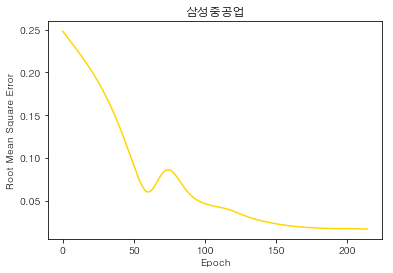

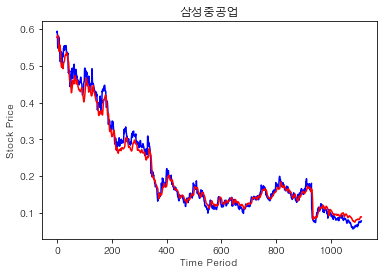

RMSE: 0.017370816
train_cnt: 210
마지막 종가(2018.09.03): 7,230
예측 종가: 7,731 (6.93%)



C:\Users\southman\Anaconda3\lib\site-packages\ipykernel_launcher.py:111: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


INFO:tensorflow:Restoring parameters from ./sessions/000270.ckpt


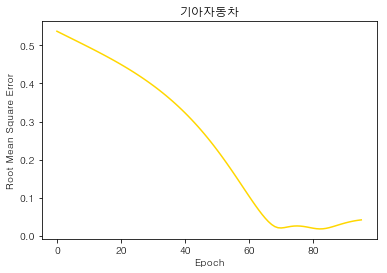

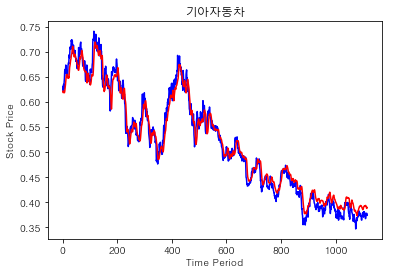

RMSE: 0.018482812
train_cnt: 82
마지막 종가(2018.09.03): 31,800
예측 종가: 32,533 (2.30%)

INFO:tensorflow:Restoring parameters from ./sessions/045390.ckpt


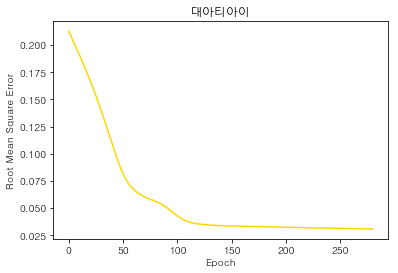

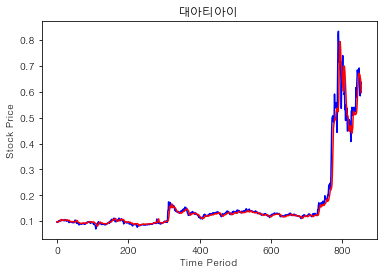

RMSE: 0.030895228
train_cnt: 280
마지막 종가(2018.09.03): 8,670
예측 종가: 7,952 (-8.28%)

INFO:tensorflow:Restoring parameters from ./sessions/063080.ckpt


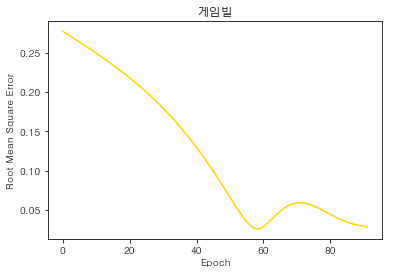

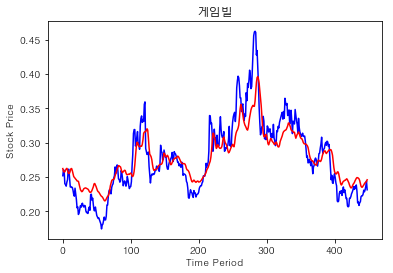

RMSE: 0.026160251
train_cnt: 58
마지막 종가(2018.09.03): 53,000
예측 종가: 57,945 (9.33%)

INFO:tensorflow:Restoring parameters from ./sessions/085370.ckpt


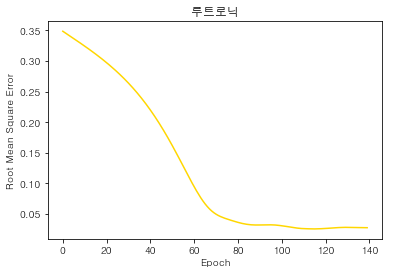

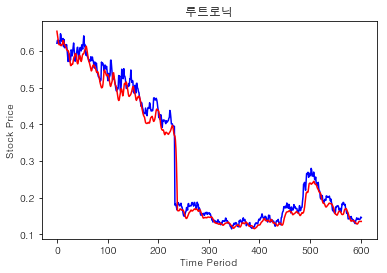

RMSE: 0.02590223
train_cnt: 115
마지막 종가(2018.09.03): 12,250
예측 종가: 11,833 (-3.40%)

INFO:tensorflow:Restoring parameters from ./sessions/003520.ckpt


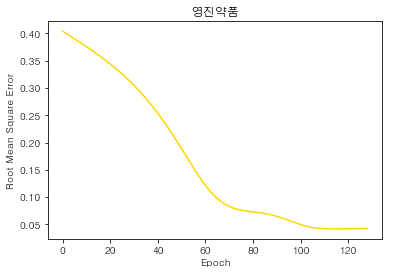

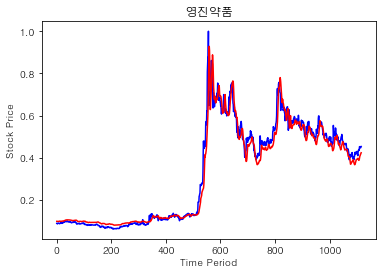

RMSE: 0.04172791
train_cnt: 115
마지막 종가(2018.09.03): 8,040
예측 종가: 7,646 (-4.90%)

INFO:tensorflow:Restoring parameters from ./sessions/215600.ckpt


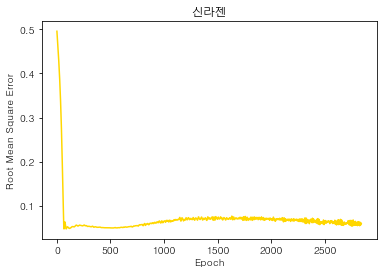

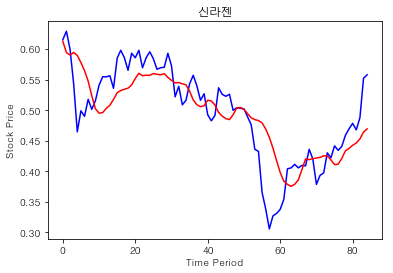

RMSE: 0.047956884
train_cnt: 66
마지막 종가(2018.09.03): 77,100
예측 종가: 66,563 (-13.67%)

INFO:tensorflow:Restoring parameters from ./sessions/028300.ckpt


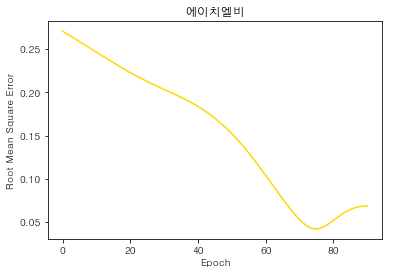

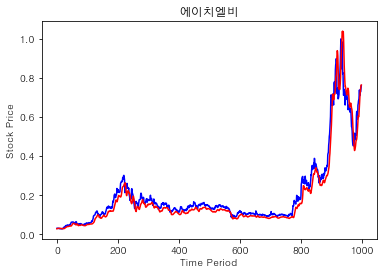

RMSE: 0.041867208
train_cnt: 75
마지막 종가(2018.09.03): 106,500
예측 종가: 101,608 (-4.59%)

INFO:tensorflow:Restoring parameters from ./sessions/035720.ckpt


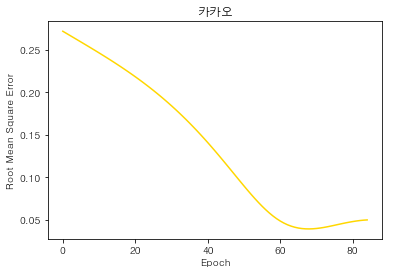

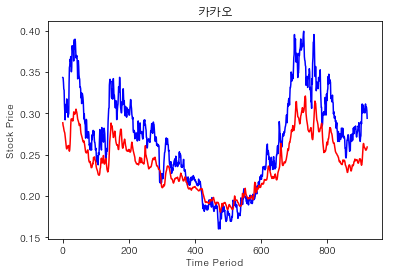

RMSE: 0.038933985
train_cnt: 68
마지막 종가(2018.09.03): 121,500
예측 종가: 120,749 (-0.62%)



In [4]:
comp_names = ["삼성중공업","기아자동차", "대아티아이","게임빌","루트로닉", "영진약품",  "신라젠", "에이치엘비", "카카오"]
for comp_name in comp_names :
    predict_next_close(comp_name)